In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install chitra

In [ ]:
pip install torchmetrics

In [ ]:
from __future__ import print_function, division
from chitra.image import Chitra
import os
import torch.nn as nn
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import torch.optim as optim
import xml.etree.ElementTree as ET
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.retinanet import RetinaNet
import warnings
import transforms as T
from torchvision.transforms import transforms as T1
from torchvision.transforms import AutoAugment
from torchvision.transforms import functional as TF
from torchvision.transforms.autoaugment import AutoAugmentPolicy
import utils
from torch.utils.data.sampler import SubsetRandomSampler
from engine import train_one_epoch
from engine import evaluate
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import models
import torch.nn.functional as F
import torch
import torchmetrics 

warnings.filterwarnings("ignore")
plt.ion()

In [ ]:
def create_corner_rect(bb, color='white'):
    bb = np.array(bb.detach(), dtype=np.float64)
    return plt.Rectangle((bb[0], bb[1]),bb[2]-bb[0], bb[3]-bb[1] , color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb, color):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb,color))

In [ ]:
data_dir = os.listdir("/content/drive/MyDrive/open-images-v6")
clase = ['Jellyfish', 'Dolphin', 'Starfish', 'Shellfish', 'Turtle']

In [ ]:
Train = pd.read_csv("/content/drive/MyDrive/open-images-v6/train/labels/detections.csv", sep=",")
Train_classes = pd.read_csv("/content/drive/MyDrive/open-images-v6/train/metadata/classes.csv", sep=",")
Train_classes.columns = ['classID', 'classname']
Train_classes = Train_classes[Train_classes['classname'].isin(clase)]
Train = Train[Train['LabelName'].isin(Train_classes['classID'])]

In [ ]:
Test = pd.read_csv("/content/drive/MyDrive/open-images-v6/test/labels/detections.csv", sep=",")
Test_classes = pd.read_csv("/content/drive/MyDrive/open-images-v6/test/metadata/classes.csv", sep=",")
Test_classes.columns = ['classID', 'classname']
Test_classes = Test_classes[Test_classes['classname'].isin(clase)]
Test = Test[Test['LabelName'].isin(Test_classes['classID'])]


Valid  = pd.read_csv("/content/drive/MyDrive/open-images-v6/validation/labels/detections.csv", sep=",")
Valid_classes = pd.read_csv("/content/drive/MyDrive/open-images-v6/validation/metadata/classes.csv", sep=",")
Valid_classes.columns = ['classID', 'classname']
Valid_classes = Valid_classes[Valid_classes['classname'].isin(clase)]
Valid = Valid[Valid['LabelName'].isin(Valid_classes['classID'])]

In [ ]:
data_train_images = os.listdir("/content/drive/MyDrive/openimages_dataset/train/data")
data_train_images = [n[:-4] for n in data_train_images]
data_test_images = os.listdir("/content/drive/MyDrive/openimages_dataset/test/data")
data_test_images = [n[:-4] for n in data_test_images]
data_validation_images = os.listdir("/content/drive/MyDrive/openimages_dataset/validation/data")
data_validation_images = [n[:-4] for n in data_validation_images]

In [ ]:
def read(Train,Train_classes,data_images):
  for iel in clase:
    Train1 = Train[Train['LabelName']==Train_classes[Train_classes['classname'] == iel]['classID'].iloc[0]]
    print('number of element in class {}'.format(iel))
    print(len(np.unique(Train1[Train1['ImageID'].isin(data_images)]['ImageID'])))

In [ ]:
# number of element in the classes in the train part
read(Train,Train_classes,data_train_images)

number of element in class Jellyfish
729
number of element in class Dolphin
886
number of element in class Starfish
436
number of element in class Shellfish
397
number of element in class Turtle
130


In [ ]:
# number of element in the classes in the test part
read(Test,Test_classes,data_test_images)

number of element in class Jellyfish
105
number of element in class Dolphin
139
number of element in class Starfish
72
number of element in class Shellfish
140
number of element in class Turtle
13


In [ ]:
# number of element in the classes in the validation part
read(Valid,Valid_classes,data_validation_images)

number of element in class Jellyfish
38
number of element in class Dolphin
61
number of element in class Starfish
21
number of element in class Shellfish
46
number of element in class Turtle
6


In [ ]:
from typing import Tuple, List, Dict, Optional
import torch
from torch import Tensor
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
def eval_forward(model, images, targets):
    # type: (List[Tensor], Optional[List[Dict[str, Tensor]]]) -> Tuple[Dict[str, Tensor], List[Dict[str, Tensor]]]
    """
    Args:
        images (list[Tensor]): images to be processed
        targets (list[Dict[str, Tensor]]): ground-truth boxes present in the image (optional)
    Returns:
        result (list[BoxList] or dict[Tensor]): the output from the model.
            It returns list[BoxList] contains additional fields
            like `scores`, `labels` and `mask` (for Mask R-CNN models).
    """
    model.eval()

    original_image_sizes: List[Tuple[int, int]] = []
    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))
    targets[0]['boxes'] = targets[0]['boxes'].squeeze(0).to(device)
    targets[0]['labels'] = targets[0]['labels'].squeeze(0).to(device)
    images, targets = model.transform(images, targets)

    # Check for degenerate boxes
    # TODO: Move this to a function
    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                # print the first degenerate box
                bb_idx = torch.where(degenerate_boxes.any(dim=1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                raise ValueError(
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}."
                )

    features = model.backbone(images.tensors)
    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])
    model.rpn.training=True
    #model.roi_heads.training=True


    #####proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())
    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)
    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)
    # apply pred_bbox_deltas to anchors to obtain the decoded proposals
    # note that we detach the deltas because Faster R-CNN do not backprop through
    # the proposals
    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}
    assert targets is not None
    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)
    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )
    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    #####detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}
    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}
    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)
    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )
    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)  # type: ignore[operator]
    model.rpn.training=False
    model.roi_heads.training=False
    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)
    return losses, detections

In [ ]:

def ensemble_learning_val_metrics(models, valid_dl, d,eval_losses,var = True):
    model.eval()
    train_accuracy = torchmetrics.Accuracy()
    i = 0
    global_accuracy = []
    for images, targets in valid_dl:
      #data preparation
        y_class = targets[0]['labels'].squeeze(0)
        images = list(image.to(device) for image in images)
        if(var == True):
          losses, detections = eval_forward(model, images, targets)
          nploss = [loss.detach().cpu() for loss in losses.values()]
          running_loss =+ np.array(nploss)
        out_class = []

       #calculating thepredictions 
        output = [model(images) for model in models]

       # extracting the predicted labels 
        for ele in output:
          out_class.append(ele[0]['labels'])

       # check for the minimum classes predicted
        check_min_classe_detected = min([len(element) for element in out_class])

       # update element
        predicted_labels = [element[:check_min_classe_detected].tolist() for element in out_class]
        predicted_labels = torch.transpose(torch.as_tensor(predicted_labels), 0, 1)

       # performing the vote majority 
        results_labels_After_voting = []
        for element in predicted_labels:
          results_labels_After_voting.append(np.argmax(np.bincount(element)))

       # Accuracy calculation
        acc = []
        for i in range(len(y_class)):
          if(y_class[i] in results_labels_After_voting):
            acc.append(True)
          else:
            acc.append(False)
        
        global_accuracy.append(np.argmax(np.bincount(acc)))
    total_train_accuracy = 100*(sum(global_accuracy)/len(valid_dl))
    if(var == True):
      eval_losses.append(running_loss)
    d.append(total_train_accuracy)
    print(f'Accuracy on all data:{total_train_accuracy}')
        
    return 

In [ ]:

def ensemble_learning_val_metrics1(models, valid_dl, eval_losses):
    model.eval()
    for images, targets in valid_dl:
      #data preparation
        y_class = targets[0]['labels'].squeeze(0)
        images = list(image.to(device) for image in images)
        losses, detections = eval_forward(model, images, targets)
        nploss = [loss.detach().cpu() for loss in losses.values()]
        running_loss =+ np.array(nploss)
    eval_losses.append(running_loss)
        
    return 

In [ ]:

def val_metrics(model, valid_dl, list_acuracy):
    model.eval()
    train_accuracy = torchmetrics.Accuracy()
    i = 0
    for images, targets in valid_dl:
        images = list(image.to(device) for image in images)
        boxes =targets[0]['boxes'].cuda()
        y_class = targets[0]['labels'].cuda()
        output = model(images)
        out_bb = output[0]['boxes']
        out_class = output[0]['labels']
        y_class = y_class.type_as(out_class)
        min1 = min(len(y_class.squeeze(0)),len(output[0]['labels']))
        if(min1==0):
          output[0]['labels'] = torch.tensor([0])
          acc = train_accuracy(output[0]['labels'].cpu().detach(),y_class.squeeze(0)[:1].cpu().detach())
        else:
          acc = train_accuracy(output[0]['labels'][:min1].cpu().detach(),y_class.squeeze(0)[:min1].cpu().detach())
    total_train_accuracy = 100*train_accuracy.compute()
    list_acuracy.append(total_train_accuracy)
    print(f'Accuracy on all data:{total_train_accuracy}')
        
    return 

In [ ]:
def get_transform1(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomPhotometricDistort())
        transforms.append(T.RandomZoomOut())
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.ScaleJitter((224,224)))
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:

class FothomDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms, Train, Train_classes):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.images_names = os.listdir(self.root)
        self.Train = Train
        self.Train_classes =Train_classes
    def __getitem__(self, idx):
        # load images and bounding boxes
        # 1st load image
        img_path = self.images_names[idx]
        img = Image.open(os.path.join(self.root,img_path)).convert("RGB")
        width, height = img.size

        # 2end extract bounding boxes
        example_of_image = self.Train[self.Train['ImageID']==img_path[:-4]]
        boxes = np.array(example_of_image[['XMin','XMax','YMin','YMax']])
        boxes[:,0] = boxes[:,0]*width
        boxes[:,1] = boxes[:,1]*width
        boxes[:,2] = boxes[:,2]*height
        boxes[:,3] = boxes[:,3]*height
        boxes =boxes[:,[0,2,1,3]]
        boxes = boxes.tolist()
        # 3erd extract labels
        labels = []
        for e in range(len(example_of_image)):
          labels.append(clase.index(self.Train_classes[example_of_image['LabelName'].iloc[e]==self.Train_classes['classID']]['classname'].iloc[0]))
        
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)
        boxe = []
        for k,elem in enumerate(boxes): 
          resize = Chitra(img,elem,labels[k] )
          resize.resize_image_with_bbox((224, 224))
          if(k == len(boxes)-1):
            img = resize.image
          boxes1 = np.concatenate(resize.bboxes[0][:], axis=None)
          boxe.append(list(boxes1))
        boxes = torch.as_tensor(boxe, dtype=torch.float32)
        '''print(img)
        print(boxes)
        print(labels[0])'''



        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        #target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        
        y= []
        y.append(target)
        #bg = T1.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        #img = bg(img)
        return img, y

    def __len__(self):
        return len(self.images_names)
    

In [ ]:
def model_choice(modeltype,num_classes): #choose between the exist model in pytorch modeltype: ['fasterrcnn, mobilenet']
    if(modeltype == 'model_0'):
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

    if(modeltype == 'model_1'):
        model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    
    if(modeltype == 'model_2'):
        model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    if(modeltype == 'model_3'):
        model = torchvision.models.detection.FasterRCNN(pretrained=True)

    if(modeltype == 'model_4'):
        model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
        return model
    num_classes = num_classes  
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has 5 classes 
num_classes = len(clase)
# use our dataset and defined transformations (our class)
dataset =  FothomDataset('/content/drive/MyDrive/open-images-v6/train/data', get_transform1(train=True),Train,Train_classes)
dataset_valid =  FothomDataset('/content/drive/MyDrive/open-images-v6/validation/data', get_transform1(train=False),Valid,Valid_classes)
dataset_test =  FothomDataset('/content/drive/MyDrive/open-images-v6/test/data', get_transform1(train=False),Test,Test_classes)
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1)

#weight = [9.36, 1.48, 12.87, 13.98, 21.18,86.83	]
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-520])
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weight, len(dataset))
# this function from torch read and prepare the data to be iterable, means data_loader contain, at each iteration, the image and the bb and the labels
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=1)

data_loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1)

# get the model using our helper function 
model = model_choice('model_0',num_classes)

# move model to the right device
model.to(device)

# construct an optimizer

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                                momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)


In [ ]:
num_epochs = 20
loss_list = []
list_train_acuracy = []
list_val_acuracy = []
eval_losses = []
loss_validation_list = []
ossas = []
ossas1 = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, loss_list, print_freq=10)
    ensemble_learning_val_metrics1([model], data_loader_valid, loss_validation_list)
    #ensemble_learning_val_metrics([model], data_loader, list_train_acuracy,eval_losses,var = False)
    #ensemble_learning_val_metrics([model], data_loader_valid, list_val_acuracy,loss_validation_list,var = True)
    #val_metrics(model, data_loader, ossas)
    #val_metrics(model, data_loader_valid, ossas1)

Epoch: [0]  [   0/2053]  eta: 0:30:07  lr: 0.000001  loss: 2.1188 (2.1188)  loss_classifier: 1.6822 (1.6822)  loss_box_reg: 0.4280 (0.4280)  loss_objectness: 0.0062 (0.0062)  loss_rpn_box_reg: 0.0025 (0.0025)  time: 0.8804  data: 0.8034  max mem: 636
Epoch: [0]  [  10/2053]  eta: 0:30:04  lr: 0.000006  loss: 2.7934 (2.8071)  loss_classifier: 1.6822 (1.6590)  loss_box_reg: 0.9835 (1.0812)  loss_objectness: 0.0267 (0.0557)  loss_rpn_box_reg: 0.0043 (0.0112)  time: 0.8834  data: 0.7882  max mem: 692
Epoch: [0]  [  20/2053]  eta: 0:30:43  lr: 0.000011  loss: 2.6535 (2.7095)  loss_classifier: 1.6763 (1.6932)  loss_box_reg: 0.9835 (0.9537)  loss_objectness: 0.0450 (0.0515)  loss_rpn_box_reg: 0.0043 (0.0112)  time: 0.9082  data: 0.8168  max mem: 703
Epoch: [0]  [  30/2053]  eta: 1:23:33  lr: 0.000016  loss: 2.6051 (2.7008)  loss_classifier: 1.6849 (1.7086)  loss_box_reg: 0.6715 (0.9145)  loss_objectness: 0.0475 (0.0641)  loss_rpn_box_reg: 0.0065 (0.0136)  time: 3.3556  data: 3.2622  max mem: 

#Loss graphs

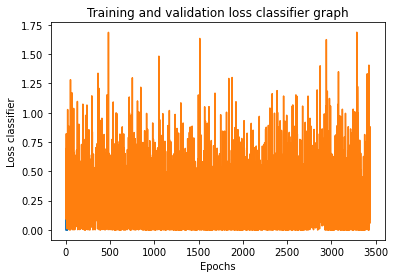

In [ ]:
ioi = []
for ele in np.asarray(loss_list)[:,0]:
  ioi.append(ele)

ioi1 = []
for ele in np.asarray(loss_validation_list)[:,0]:
  ioi1.append(ele)

plt.plot(ioi)
plt.plot(ioi1)
plt.xlabel("Epochs")
plt.ylabel("Loss classifier")
plt.title("Training and validation loss classifier graph")
plt.savefig('Training loss classifier graph')

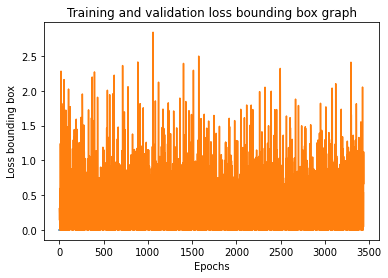

In [ ]:
ioi = []
for ele in np.asarray(loss_list)[:,1]:
  ioi.append(ele)

ioi1 = []
for ele in np.asarray(loss_validation_list)[:,1]:
  ioi1.append(ele)

plt.plot(ioi)
plt.plot(ioi1)
plt.xlabel("Epochs")
plt.ylabel("Loss bounding box")
plt.title("Training and validation loss bounding box graph")
plt.savefig('Training loss bounding box graph')

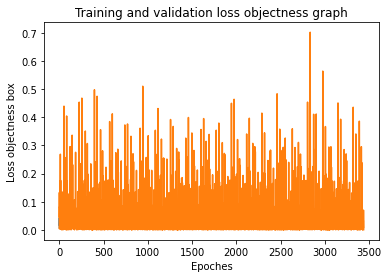

In [ ]:
ioi = []
for ele in np.asarray(loss_list)[:,2]:
  ioi.append(ele)

ioi1 = []
for ele in np.asarray(loss_validation_list)[:,2]:
  ioi1.append(ele)

plt.plot(ioi)
plt.plot(ioi1)
plt.xlabel("Epoches")
plt.ylabel("Loss objectness box")
plt.title("Training and validation loss objectness graph")
plt.savefig('Training loss objectness graph')

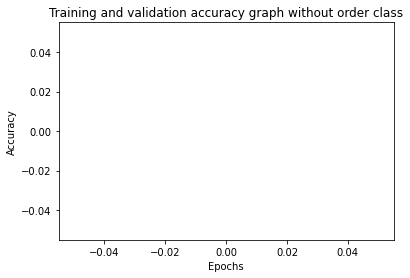

In [ ]:
ioi = []
plt.plot(list_train_acuracy)
plt.plot(list_val_acuracy)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy graph without order class")
plt.savefig('Training and validation accuracy')

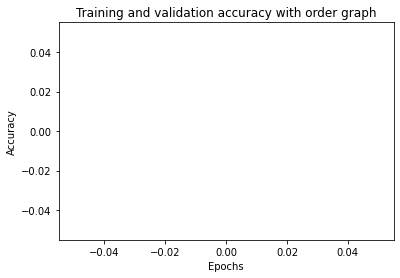

In [ ]:
ioi = []
#for ale,ele in zip(list_train_acuracy,list_val_acuracy):
#  ioi.append(ele)
plt.plot(ossas)
plt.plot(ossas1)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy with order graph")
plt.savefig('Training and validation accuracy')

#Calculate accuracy 

In [ ]:
checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, 'checkpoint_frcnnm_bn.pth')

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model1 = model_choice('model_1',num_classes)
model1 = model1.to(device)
checkpoint = torch.load('checkpoint_frcnnm_bn.pth')
model1.load_state_dict(checkpoint['state_dict'])
model1.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth


  0%|          | 0.00/74.2M [00:00<?, ?B/s]

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
          )
        )
      )
      (2): InvertedResidual(
        (block): Seque

In [ ]:
d = []
val_metrics(model1, data_loader_test,d)

Accuracy on all data:83.35147094726562


In [ ]:
d = []
val_metrics(model1, data_loader_valid,d)

Accuracy on all data:81.96720886230469


In [ ]:
d = []
val_metrics(model1, data_loader,d)

Accuracy on all data:61.62858581542969


#take some image for test

In [ ]:
import random
labelsl = clase
    
# choose randomly five image to test our mpdel visualy
data_rot = '/content/drive/MyDrive/openimages_dataset/test/data'
image_name = os.listdir(data_rot) 
# pick randomly five image name from the test folder
test_image = random.sample(image_name,5)



In [ ]:
# choose a number between 0 to 4
b = 4 


#this calculate the image classes
nnn = Test[Test['ImageID']==test_image[b][:-4]]['LabelName']
images_classe = []
for ele in nnn:
  images_classe.append(Test_classes[Test_classes['classID']==ele]['classname'].iloc[0])
img = Image.open(os.path.join(data_rot,test_image[b])).convert("RGB")
img = img.resize((224,224))
transformTotensor = T1.Compose([T1.ToTensor()])
img1 = transformTotensor(img)
img1 = img1.unsqueeze(0)
img1 = img1.to(device)

loss = model1(img1)

try :
  labelssss = loss[0]['labels'][0]
  
except:
  labelssss = 0

image = Chitra(img, bboxes=loss[0]['boxes'][2].cpu().detach().numpy(), labels=labelsl[labelssss])
plt.imshow(image.draw_boxes())

print('the labels provided by our model are')
for i in loss[0]['labels'][:]:
    print(labelsl[i])
    print('-----------------')

print('the real labels ')
for i in images_classe:
    print(i)
    print('-----------------')


#perform the ensemble learning

In [ ]:
model1 = model_choice('model_0',num_classes)
model1 = model1.to(device)
path_to_first_model = '/content/drive/MyDrive/saved/checkpoint_frcnnm_bn_model0.pth'
checkpoint = torch.load(path_to_first_model)
model1.load_state_dict(checkpoint['state_dict'])
model1.eval()

model2 = model_choice('model_1',num_classes)
model2 = model2.to(device)
path_to_second_model = '/content/drive/MyDrive/saved/checkpoint_frcnnm_bn_model1.pth'
checkpoint = torch.load(path_to_second_model)
model2.load_state_dict(checkpoint['state_dict'])
model2.eval()

model3 = model_choice('model_2',num_classes)
model3 = model3.to(device)
path_to_3erd_model = '/content/drive/MyDrive/saved/checkpoint_frcnnm_bn_model2.pth'
checkpoint = torch.load(path_to_3erd_model)
model3.load_state_dict(checkpoint['state_dict'])
model3.eval()

model4 = model_choice('model_4',num_classes)
model4 = model4.to(device)
path_to_4erd_model = '/content/drive/MyDrive/saved/checkpoint_frcnnm_bn_model4.pth'
checkpoint = torch.load(path_to_4erd_model)
model4.load_state_dict(checkpoint['state_dict'])
model4.eval()



In [ ]:
# ensemble learning validation
ensemble_learning_val_metrics([model1,model2,model3,model4], data_loader_valid)

In [ ]:
# fast rcnn mobilenet validation 320 large
ensemble_learning_val_metrics([model1], data_loader_valid)

In [ ]:
# fast rcnn mobilenet validation large
ensemble_learning_val_metrics([model2], data_loader_valid)

In [ ]:
# fact res net validation
ensemble_learning_val_metrics([model3], data_loader_valid)

In [ ]:
# retina validation 
ensemble_learning_val_metrics([model4], data_loader_valid)

In [ ]:
# retina test 
ensemble_learning_val_metrics([model4], data_loader_test)

In [ ]:
# fact res net test
ensemble_learning_val_metrics([model3], data_loader_test)

In [ ]:
# fast rcnn mobilenet test large
ensemble_learning_val_metrics([model2], data_loader_test)

In [ ]:
# fast rcnn mobilenet test 320 large
ensemble_learning_val_metrics([model1], data_loader_test)

In [ ]:
# ensemble learning test
ensemble_learning_val_metrics([model1,model2,model3,model4], data_loader_test)